## _STT HitPairs_

1. **_prepare data_**:_`hitpairs`_
2. **_data input pipeline_**:_`tf.data.Dataset`_
3. **_functional/subclassing api_**:_`tf.keras.Model`_
4. **_fitted/custom training loops_**:_`tf.keras.Model.fit`/`GradientTape`_

### _4. Testing Model_

In [1]:
import sys, os, glob, yaml
sys.path.append('src')

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook, tnrange
from sklearn.model_selection import train_test_split

import tensorflow as tf
import trackml.dataset

%matplotlib inline

In [3]:
from dutils import load_event_hits, load_event
from models import HitPairsANNS_TrackML_Small
from drawing import draw_train_history, draw_single_event
from pairs import construct_pairs, construct_pairs_hard

In [4]:
# tf.keras.backend.set_floatx('float64')

### _Configs (YAML)_

In [5]:
# load config
with open('configs/prep_stt.yaml') as f:
    config = yaml.safe_load(f)
    
# get data
input_dir = os.path.expandvars(config['input_dir'])
print(input_dir)

/home/adeak977/current/data_sets/pandaml/data-3-7-GeV/


### _Event Vizualization_

In [6]:
def display_event(path="", event_id=1):
    prefix = path + str('event{!s}'.format(format(event_id, '010d')))
    hits = load_event_hits(prefix)
    draw_single_event(event=hits, event_id=event_id, figsize=(8, 8));

In [7]:
# display_event(input_dir, 1)

### _Input Pipeline_

In [8]:
# prepare data (three version slightly different)
X, y = construct_pairs(path=input_dir, start=0, end=100)
# X, y = prepare_pairs(path=input_dir, start=0, end=100)
# X, y = prepare_pairs_list(path=input_dir, start=0, end=100)

processing  event0000000000
processing  event0000000010
processing  event0000000020
processing  event0000000030
processing  event0000000040
processing  event0000000050
processing  event0000000060
processing  event0000000070
processing  event0000000080
processing  event0000000090



In [9]:
X.shape, y.shape

((2036954, 8), (2036954, 1))

In [10]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [11]:
# make tf.data.Dataset object from numpy for training and testing
# batch_size = 1024
# trainset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
# testset= tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

## _4 - Testing Model_

- directly start at testing.

In [12]:
try:
    model
except NameError:
    print('load model')
    model = tf.keras.models.load_model('saved/sol2_stt_hard.h5')

load model


In [13]:
event_id = 0
event_prefix = str('event{!s}'.format(format(event_id, '010d')))
prefix = input_dir + event_prefix
    
hits, tubes, particles, truth = load_event(prefix)

In [14]:
hits.head()

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
0,1,-16.6190,-1.515,35.0,28,0,0,1,9,0.049925,16256100.0,16.25610,10
1,2,-17.4937,-2.020,35.0,134,0,1,1,9,0.281159,9955910.0,9.95591,10
2,3,-18.3684,-1.515,35.0,245,0,2,1,9,0.413188,3994340.0,3.99434,10
3,4,-19.2431,-2.020,35.0,363,0,3,1,9,0.141190,12391400.0,12.39140,10
4,5,-20.1178,-2.525,35.0,487,0,4,1,9,0.159385,6038700.0,6.03870,10


In [15]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,particle_id
0,1,-16.6125,-1.54537,18.0768,-0.237797,-0.051115,0.268606,10
1,2,-17.5543,-1.75329,19.1420,-0.237263,-0.053999,0.268492,10
2,3,-18.2722,-1.91963,19.9554,-0.236697,-0.056308,0.268482,10
3,4,-19.2105,-2.14995,21.0217,-0.235934,-0.059223,0.268491,10
4,5,-20.1527,-2.39287,22.0953,-0.235313,-0.062231,0.268327,10


In [16]:
tubes.head()

,hit_id,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss
0,1,28,0,0,1,9,0.049925,16256100.0,16.25610
1,2,134,0,1,1,9,0.281159,9955910.0,9.95591
2,3,245,0,2,1,9,0.413188,3994340.0,3.99434
3,4,363,0,3,1,9,0.141190,12391400.0,12.39140
4,5,487,0,4,1,9,0.159385,6038700.0,6.03870


In [17]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,pdg_code,start_time
0,10,0,0,0,-0.253479,0.002213,0.267032,-1,13,0
1,10,0,0,0,-0.253479,0.002213,0.267032,-1,13,0
2,10,0,0,0,-0.253479,0.002213,0.267032,-1,13,0
3,10,0,0,0,-0.253479,0.002213,0.267032,-1,13,0
4,10,0,0,0,-0.253479,0.002213,0.267032,-1,13,0


In [18]:
features = hits[['x','y', 'isochrone', 'energyloss']].values
features.shape

(230, 4)

In [19]:
gl = hits.groupby(['layer_id'])

In [20]:
gl.first()

,hit_id,x,y,z,tube_id,skewed,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
layer_id,,,,,,,,,,,,
0,1,-16.6190,-1.51500,35.0,28,0,1,9,0.049925,16256100.0,16.25610,10
1,2,-17.4937,-2.02000,35.0,134,0,1,9,0.281159,9955910.0,9.95591,10
2,3,-18.3684,-1.51500,35.0,245,0,1,9,0.413188,3994340.0,3.99434,10
3,4,-19.2431,-2.02000,35.0,363,0,1,9,0.141190,12391400.0,12.39140,10
4,5,-20.1178,-2.52500,35.0,487,0,1,9,0.159385,6038700.0,6.03870,10
5,6,-20.9925,-3.03000,35.0,617,0,1,9,0.392294,9489860.0,9.48986,10
6,7,-21.8671,-2.52500,35.0,752,0,1,9,0.309516,12475900.0,12.47590,10
7,8,-22.7418,-3.03000,35.0,894,0,1,9,0.093093,5295920.0,5.29592,10
8,9,-23.7518,-2.91920,35.0,1045,1,1,9,0.066169,9184270.0,9.18427,10


In [21]:
hits_l = gl.get_group(1)
hits_l

,hit_id,x,y,z,tube_id,skewed,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
1,2,-17.49370,-2.020,35.0,134,0,1,9,0.281159,9955910.0,9.95591,10
25,26,-16.61900,-10.605,35.0,143,0,2,9,0.075616,8078550.0,8.07855,9
47,48,-11.37090,13.635,35.0,115,0,0,9,0.359282,4906000.0,4.90600,8
95,96,7.87217,15.655,35.0,208,0,5,9,0.294644,6864620.0,6.86462,6
122,123,-7.87217,15.655,35.0,111,0,0,9,0.141620,5181540.0,5.18154,5
153,154,17.49370,-4.040,35.0,183,0,4,9,0.376862,5256800.0,5.25680,3
178,179,17.49370,-4.040,35.0,183,0,4,9,0.178137,4842370.0,4.84237,2
204,205,17.49370,2.020,35.0,189,0,4,9,0.395623,3035140.0,3.03514,1


In [22]:
# single column is a Series
hits_l['hit_id']

1        2
25      26
47      48
95      96
122    123
153    154
178    179
204    205
Name: hit_id, dtype: int64

In [23]:
# let count the number of hits
hits_l['hit_id'].count()

8

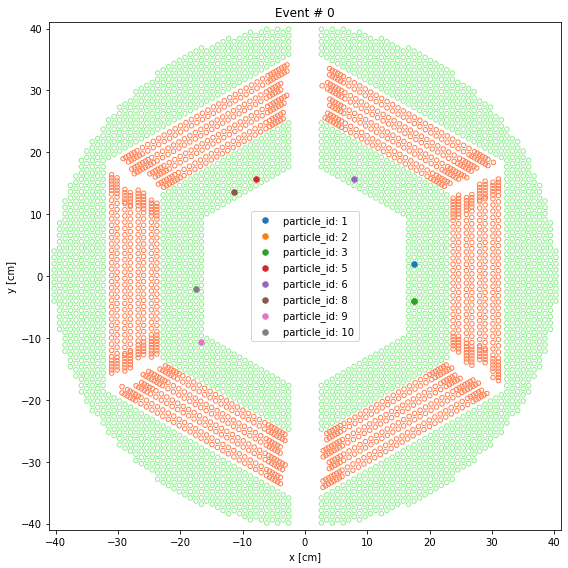

In [24]:
draw_single_event(event=hits_l, event_id=0, figsize=(8, 8));

In [25]:
count = hits.groupby(['layer_id'])['hit_id'].count().values

In [26]:
len(count)

26

### _Tranformation from ATLAS to STT_

- `volume_id` can be skipped. STT is only one volume. But maybe in full PANDA detector, we have to assign one to distinguish it from MVD, GEM etc.

- `volume_id` can be transformed as `sector_id` in STT, but can be extended into full PANDA subdetectors treated as `volumes`.

- `layer_id`: for a particular `volume_id/sector_id`, we have `layer_ids`. e.g. `layer_id = 0,1,2,...,25`
- `tube_id`: for specific `volume_id` and `layer_id` we have `tube_ids`


Let's first perform some EDA on ATLAS data.

In [27]:
# fetch an event from trackml dataset

event_prefix = 'event000001000'
path = os.environ['HOME']+'/current/data_sets/trackml/train_100_events/'
prefix = path + event_prefix

hits, cells, particles, truth = trackml.dataset.load_event(prefix)

In [28]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [29]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [30]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [31]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [32]:
hit_cells = cells.groupby(['hit_id']).value.count().values      # number of tubes, counts
hit_value = cells.groupby(['hit_id']).value.sum().values        # tube values e.g. deposited charge or energyloss
features = np.hstack((hits[['x','y','z']]/1000, hit_cells.reshape(len(hit_cells),1)/10,hit_value.reshape(len(hit_cells),1)))

In [33]:
# count of all tube_ids (module_ids)
count = hits.groupby(['volume_id','layer_id','module_id'])['hit_id'].count().values   # we don't have volume_id, 
module_id = np.zeros(len(hits), dtype='int32')    # equivalent of tube_id, in a layer_id

In [34]:
# list of module ids, index of array contain the module_id.
for i in range(len(count)):
    si = np.sum(count[:i])
    module_id[si:si+count[i]] = i

In [35]:
module_id

array([    0,     0,     0, ..., 17470, 17470, 17470], dtype=int32)

In [37]:
np.sum(count[:1])

21

### What is Test Time Augmentation (TTA)?
Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess. See more on [TTA](https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d)

In [249]:
def get_predict(hit, thr=0.5):
    """
    The function to get prediction on testset. Use Test Time Augmentation (TTA)
    to find the average prediction on the testset.
    """
    # First create test data as pairs. Use np.tile for broadcasting. 
    # Tx = testset pairs = [features of hit_0, hit_i], i=0,1,...,N=len(hits)
    Tx = np.zeros((len(truth),10))
    Tx[:,5:] = features
    Tx[:,:5] = np.tile(features[hit], (len(Tx), 1))
    pred = model.predict(Tx, batch_size=len(Tx))[:,0]
    
    # TTA: Test Time Augmentation
    # first get indices of pred where prediction > threshold
    idx = np.where(pred > thr)[0]
    
    # build a new testset based on above indices i.e. idx
    Tx2 = np.zeros((len(idx),10))
    Tx2[:,5:] = Tx[idx,:5]
    Tx2[:,:5] = Tx[idx,5:]    
    pred2 = model.predict(Tx2, batch_size=len(idx))[:,0]
    
    # get average pred=(pred1+pred2)/2, remember to get pred1 from pred as 
    # the following to match the dimensions.
    pred1 = pred[idx]
    
    pred[idx] = (pred1 + pred2)/2
    return pred

In [ ]:
def get_path(hit, mask, thr):
    path = [hit]
    a = 0
    while True:
        c = get_predict(path[-1], thr/2)
        mask = (c > thr)*mask
        mask[path[-1]] = 0
        
        if 1:
            cand = np.where(c>thr)[0]
            if len(cand)>0:
                mask[cand[np.isin(module_id[cand], module_id[path])]]=0
                
        a = (c + a)*mask
        if a.max() < thr*len(path):
            break
        path.append(a.argmax())
    return path

# Step 5 - Predict and Score
